# National Hockey League (NHL) Player Stats 2017-2020

## Final Project Report for Data 311 Fall 2020 University of Calgary

**Cole Narfason and Greg Brown**

## Data Import & Cleaning

Import Necessary Libraries - Pandas, Numpy, Seaborn, Matplotlib

In [1]:
##Import Pandas, Numpy, seaborn & matplotlib Packages##
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Import the data **Please use the attached file 'StatSum17_20** which contains raw NHL player stats from the 2017 - 2020

In [2]:
## Import Data ###
data = "StatSum17_20.csv"
df = pd.read_csv(data)


Now make a couple of column changes:
1. Change 'Player' column to just 'Name' to avoid having a relation the same name as a column
2. Create a unique Player Number or 'PNum' column to differentiate players

In [3]:
## Index is reset to get a column of unique numbers.
## This column will become PNum which is the primary key for the Player table###
df.reset_index(level=0, inplace=True)
###Change the title of "Player" attribute to Name###
df=df.rename(columns = {'Player':'Name'})
#Change some other column names too
df2 = df.rename(columns = {'index': 'PNum'})
df2=df2.rename(columns = {'S/C': 'SC'})
df2=df2.rename(columns = {'Team': 'TName'})

### Create a relation for NHL Teams (Table 1)

**Note:** If a player got traded mid-season then he will have played for 2 NHL Teams that season which will show up as (Team1, Team2), this is why TNum is important because as well as having a unique number for each NHL team - it will have a unique TNum for different combos of Teams NHL Players will have played for in a season. 

In [4]:
##Build data frame for Team ###
Teams = df2.iloc[:,[3]]
##eliminate any duplicate Team Names###
Teams = Teams.drop_duplicates()

##Index gives us a number to assign to each team###
Teams.reset_index(level=0, inplace=True)
##Rename the index column###
Teams = Teams.rename(columns = {'index': 'TNum'})
Teams.head(30)

,TNum,TName
0,0,TBL
1,1,EDM
2,2,CHI
3,6,PHI
4,8,BOS
5,9,PIT
6,10,COL
7,11,CGY
8,16,FLA
9,18,NYR


# Connect Teams Table to MySQL

In [29]:
import mysql.connector
from mysql.connector import Error

try: 
    #Attempt to connect
    connection = mysql.connector.connect(user = 'root', 
                                         password = 'Flames2020', 
                                         host = '127.0.0.1', 
                                         database = 'nhl_schema')
    #Get some information regarding our connection
    if connection.is_connected():
        db_Info = connection.get_server_info()
        print("Connected to MySQL Server version:",db_Info)
        cursor = connection.cursor()
        
        cursor.execute("SELECT database();")
        record = cursor.fetchone()
        print("You are connected to the database",record)
        
       
        for row in Teams.itertuples():
            cursor.execute('''INSERT INTO nhl_schema.teams (TNum, TName)
                            VALUES (%s, %s)
                            ''', 
                          (row.TNum,
                          row.TName))
        connection.commit()

except Error as e: 
    print("Error while connecting to MySQL: ", e)
    
finally:
    if connection.is_connected():
        cursor.close()
        connection.close()
        print("MySQL connection is closed.")


Connected to MySQL Server version: 8.0.22
You are connected to the database ('nhl_schema',)
Error while connecting to MySQL:  1062 (23000): Duplicate entry '0' for key 'teams.PRIMARY'
MySQL connection is closed.


### Create a relation for NHL Player info (Table 2)

**Note:** Players names will show up multiple times because they would have played in multiple seasons from 2017 - 2020. There is also a very small chance that a player could have the same name as another player - this is why having a unique PNum is important.

In [5]:
### Build A data frame for Player by choosing specific columns###
play = df2.iloc[:,[0,1,3,4,5]]

#Add a foreign key from Teams into Players
play1 = pd.merge(play, Teams, on = 'TName', how = 'left')
#Drop the TName String Column
players = play1.iloc[:,[0, 1, 3, 4, 5]]
#Take a Peak
players.head(20)

,PNum,Name,SC,Pos,TNum
0,0,Nikita Kucherov,L,R,0
1,1,Connor McDavid,L,C,1
2,2,Patrick Kane,L,R,2
3,3,Leon Draisaitl,L,C,1
4,4,Connor McDavid,L,C,1
5,5,Leon Draisaitl,L,C,1
6,6,Claude Giroux,R,C,6
7,7,Nikita Kucherov,L,R,0
8,8,Brad Marchand,L,L,8
9,9,Sidney Crosby,L,C,9


## Connect to  Players Table to MySQL

In [7]:
import mysql.connector
from mysql.connector import Error

try: 
    #Attempt to connect
    connection = mysql.connector.connect(user = 'root', 
                                         password = 'Flames2020', 
                                         host = '127.0.0.1', 
                                         database = 'nhl_schema')
    #Get some information regarding our connection
    if connection.is_connected():
        db_Info = connection.get_server_info()
        print("Connected to MySQL Server version:",db_Info)
        cursor = connection.cursor()
        
        cursor.execute("SELECT database();")
        record = cursor.fetchone()
        print("You are connected to the database",record)
        
       #Put DF columns into MySQL
        for row in players.itertuples():
            cursor.execute('''INSERT INTO nhl_schema.players (PNum, Name, SC, Pos, TNum)
                            VALUES (%s, %s, %s, %s, %s)
                            ''', 
                          (row.PNum,
                          row.Name,
                          row.SC,
                          row.Pos,
                          row.TNum))
        connection.commit()
#deal with errors
except Error as e: 
    print("Error while connecting to MySQL: ", e)
    
finally:
    if connection.is_connected():
        cursor.close()
        connection.close()
        print("MySQL connection is closed.")


Connected to MySQL Server version: 8.0.22
You are connected to the database ('nhl_schema',)
MySQL connection is closed.


### Create a relation for NHL Player Stats (Table 3)

We will need to change a few column names that have special characters which could cause errors later on

In [6]:
###Build data frame for stats ###
stats = df2.iloc[:,[0,2,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,23]]

###Many columns have names with key characters. These need to by changed###
stats=stats.rename(columns = {'+/-': 'plusminus'})
stats=stats.rename(columns = {'P/GP': 'PPGP'})
stats=stats.rename(columns = {'TOI/GP': 'TIME'})

#Take a peek at what it looks like
stats.head(20)

,PNum,Season,GP,G,A,P,plusminus,PIM,PPGP,EVG,EVP,PPG,PPP,SHG,SHP,OTG,GWG,S,TIME
0,0,20182019,82,41,87,128,24,62,1.56,26,80,15,48,0,0,0,8,246,19:58
1,1,20182019,78,41,75,116,3,20,1.49,31,81,9,33,1,2,3,9,240,22:50
2,2,20182019,81,44,66,110,2,22,1.36,35,80,9,30,0,0,3,7,341,22:29
3,3,20192020,71,43,67,110,-7,18,1.55,27,66,16,44,0,0,2,10,218,22:37
4,4,20172018,82,41,67,108,20,26,1.32,35,84,5,20,1,4,2,7,274,21:33
5,5,20182019,82,50,55,105,2,52,1.28,31,73,16,29,3,3,3,5,231,22:35
6,6,20172018,82,34,68,102,28,20,1.24,25,66,9,36,0,0,1,1,193,20:22
7,7,20172018,80,39,61,100,15,42,1.25,31,64,8,36,0,0,0,7,279,19:49
8,8,20182019,79,36,64,100,15,96,1.27,23,59,10,34,3,7,3,9,231,19:37
9,9,20182019,79,35,65,100,18,36,1.27,23,69,12,29,0,2,1,3,220,21:00


# Connect Stats Table to MySQL

In [44]:
import mysql.connector
from mysql.connector import Error

try: 
    #Attempt to connect
    connection = mysql.connector.connect(user = 'root', 
                                         password = 'Flames2020', 
                                         host = '127.0.0.1', 
                                         database = 'nhl_schema')
    #Get some information regarding our connection
    if connection.is_connected():
        db_Info = connection.get_server_info()
        print("Connected to MySQL Server version:",db_Info)
        cursor = connection.cursor()
        
        cursor.execute("SELECT database();")
        record = cursor.fetchone()
        print("You are connected to the database",record)
        
       
        for row in stats.itertuples():
            cursor.execute('''INSERT INTO nhl_schema.stats (PNum, Season, GP, G, A, P, plusminus, PIM, PPGP, EVG, EVP, PPG, PPP,
                                                            SHG, SHP, OTG, GWG, S, TIME)
                            VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
                            ''', 
                          (row.PNum,
                          row.Season,
                          row.GP,
                          row.G,
                          row.A,
                          row.P,
                          row.plusminus,
                          row.PIM,
                          row.PPGP,
                          row.EVG,
                          row.EVP,
                          row.PPG,
                          row.PPP,
                          row.SHG,
                          row.SHP,
                          row.OTG,
                          row.GWG,
                          row.S,
                          row.TIME))
        connection.commit()

except Error as e: 
    print("Error while connecting to MySQL: ", e)
    
finally:
    if connection.is_connected():
        cursor.close()
        connection.close()
        print("MySQL connection is closed.")


Connected to MySQL Server version: 8.0.22
You are connected to the database ('nhl_schema',)
MySQL connection is closed.


# DEMO

### Questions

# Question 1 : What were the Top 10 NHL players in 2019-2020 based on Points?

In [29]:
#Access MySQL
import mysql.connector
from mysql.connector import Error

try: 
    #Attempt to connect
    connection = mysql.connector.connect(user = 'root', 
                                         password = 'Flames2020', 
                                         host = '127.0.0.1', 
                                         database = 'nhl_schema')
        
        
    #Get some information regarding our connection
    if connection.is_connected():
        db_Info = connection.get_server_info()
        print("Connected to MySQL Server version:",db_Info)
        cursor = connection.cursor()
        
        cursor.execute("SELECT database();")
        record = cursor.fetchone()
        print("You are connected to the database",record)
        
        
        #SQL Queries
        cursor.execute("SELECT P.Name, S.P FROM players as P, stats as S WHERE P.PNum = S.PNum AND S.Season = '20192020' ORDER BY S.P DESC LIMIT 10;")
        result1 = cursor.fetchall()
        print(result1)
        

except Error as e: 
    print("Error while connecting to MySQL: ", e)
    
finally:
    if connection.is_connected():
        cursor.close()
        connection.close()
        print("MySQL connection is closed.")



Connected to MySQL Server version: 8.0.22
You are connected to the database ('nhl_schema',)
[('Leon Draisaitl', 110), ('Connor McDavid', 97), ('David Pastrnak', 95), ('Artemi Panarin', 95), ('Nathan MacKinnon', 93), ('Brad Marchand', 87), ('Nikita Kucherov', 85), ('Patrick Kane', 84), ('Auston Matthews', 80), ('Jack Eichel', 78)]
MySQL connection is closed.


In [30]:
#make df from query results
from pandas import DataFrame
Q1 = DataFrame (result1, columns=['Name', 'P'])
Q1

,Name,P
0,Leon Draisaitl,110
1,Connor McDavid,97
2,David Pastrnak,95
3,Artemi Panarin,95
4,Nathan MacKinnon,93
5,Brad Marchand,87
6,Nikita Kucherov,85
7,Patrick Kane,84
8,Auston Matthews,80
9,Jack Eichel,78


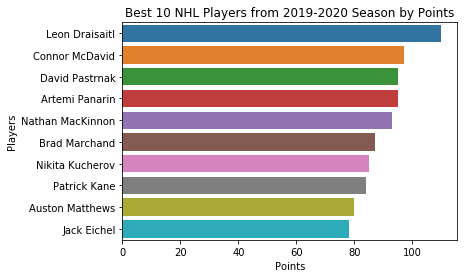

In [31]:
#Create horizontal Bar Chart
a1 = sns.barplot(y="Name", x="P", data= Q1)
a1.set_title("Best 10 NHL Players from 2019-2020 Season by Points")
a1.set_xlabel("Points")
a1.set_ylabel("Players")
a1.set_yticklabels( labels = Q1["Name"])
plt.show()

# Question 2: How did my favourite player Sidney Crosby perform the past 3 NHL Seasons based on point totals?

In [32]:
#Access MySQL
import mysql.connector
from mysql.connector import Error

try: 
    #Attempt to connect
    connection = mysql.connector.connect(user = 'root', 
                                         password = 'Flames2020', 
                                         host = '127.0.0.1', 
                                         database = 'nhl_schema')
        
        
    #Get some information regarding our connection
    if connection.is_connected():
        db_Info = connection.get_server_info()
        print("Connected to MySQL Server version:",db_Info)
        cursor = connection.cursor()
        
        cursor.execute("SELECT database();")
        record = cursor.fetchone()
        print("You are connected to the database",record)
        
        
        #SQL Queries
        cursor.execute("SELECT S.Season, P.Name, S.P FROM players as P, stats as S WHERE P.PNum = S.PNum AND Name = 'Sidney Crosby' ORDER BY S.Season;")
        result2 = cursor.fetchall()
        print(result2)
        

        

except Error as e: 
    print("Error while connecting to MySQL: ", e)
    
finally:
    if connection.is_connected():
        cursor.close()
        connection.close()
        print("MySQL connection is closed.")

#Create Df for query results
Q2 = DataFrame (result2, columns=['Season','Name', 'P'])
Q2

Connected to MySQL Server version: 8.0.22
You are connected to the database ('nhl_schema',)
[('20172018', 'Sidney Crosby', 89), ('20182019', 'Sidney Crosby', 100), ('20192020', 'Sidney Crosby', 47)]
MySQL connection is closed.


,Season,Name,P
0,20172018,Sidney Crosby,89
1,20182019,Sidney Crosby,100
2,20192020,Sidney Crosby,47


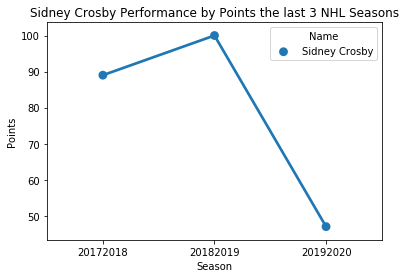

In [33]:
#Create Line chart
a2 = sns.pointplot(x="Season", y="P", hue ="Name" , data= Q2)
a2.set_title("Sidney Crosby Performance by Points the last 3 NHL Seasons")
a2.set_ylabel("Points")
a2.set_xlabel("Season")
a2.set_xticklabels( labels = Q2["Season"])
plt.show()

#Show picture of Sid with a moustache
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "http://images.performgroup.com/di/library/omnisport/98/91/sidney-crosby-111418-usnews-getty-ftr_a3eq7auh1fmh1d6ltpjdc5nry.jpg")

# Question 3: In 2018-2019 what is the proportion of NHL players that played each position?

In [12]:
#Access MySQL
import mysql.connector
from mysql.connector import Error

try: 
    #Attempt to connect
    connection = mysql.connector.connect(user = 'root', 
                                         password = 'Flames2020', 
                                         host = '127.0.0.1', 
                                         database = 'nhl_schema')
        
        
    #Get some information regarding our connection
    if connection.is_connected():
        db_Info = connection.get_server_info()
        print("Connected to MySQL Server version:",db_Info)
        cursor = connection.cursor()
        
        cursor.execute("SELECT database();")
        record = cursor.fetchone()
        print("You are connected to the database",record)
        
        
        #SQL Queries
        cursor.execute("SELECT P.Pos, Count(P.Pos) FROM players as P, stats as S WHERE P.PNum = S.PNum AND S.Season = '20182019' GROUP BY P.Pos;")
        result3 = cursor.fetchall()
        

        

except Error as e: 
    print("Error while connecting to MySQL: ", e)
    
finally:
    if connection.is_connected():
        cursor.close()
        connection.close()
        print("MySQL connection is closed.")

#Make Df from query results
Q3 = DataFrame (result3, columns=['Pos','Number of Players'])
Q3.head()

Connected to MySQL Server version: 8.0.22
You are connected to the database ('nhl_schema',)
MySQL connection is closed.


,Pos,Number of Players
0,R,134
1,C,286
2,L,169
3,D,324


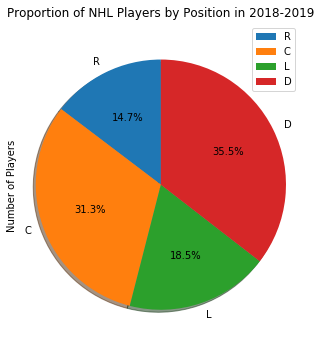

In [13]:
#Create a Pie Chart
Q3['Number of Players'].plot(kind='pie',
                            figsize=(5, 6),
                            autopct='%1.1f%%', # add in percentages
                            startangle=90,     # start angle 90° 
                            shadow=True,
                            labels= Q3["Pos"]           
                            )

plt.title('Proportion of NHL Players by Position in 2018-2019')
plt.axis('equal') # Sets the pie chart to look like a circle.
plt.legend(labels=Q3.Pos, loc='upper right')

plt.show()

# Question 4: What Players had the most goals in 2017-2018?

In [14]:
#Access MySQL
import mysql.connector
from mysql.connector import Error

try: 
    #Attempt to connect
    connection = mysql.connector.connect(user = 'root', 
                                         password = 'Flames2020', 
                                         host = '127.0.0.1', 
                                         database = 'nhl_schema')
        
        
    #Get some information regarding our connection
    if connection.is_connected():
        db_Info = connection.get_server_info()
        print("Connected to MySQL Server version:",db_Info)
        cursor = connection.cursor()
        
        cursor.execute("SELECT database();")
        record = cursor.fetchone()
        print("You are connected to the database",record)
        
        
        #SQL Queries
        cursor.execute("SELECT P.Name, S.G FROM players as P, stats as S WHERE P.PNum = S.PNum AND S.Season = '20172018' ORDER BY S.G DESC LIMIT 15;")
        result4 = cursor.fetchall()
        print(result4)
        

        

except Error as e: 
    print("Error while connecting to MySQL: ", e)
    
finally:
    if connection.is_connected():
        cursor.close()
        connection.close()
        print("MySQL connection is closed.")
#Create Df of query results
Q4 = DataFrame (result4, columns=['Name', 'Goals Scored'])
Q4

Connected to MySQL Server version: 8.0.22
You are connected to the database ('nhl_schema',)
[('Alex Ovechkin', 49), ('Patrik Laine', 44), ('William Karlsson', 43), ('Evgeni Malkin', 42), ('Eric Staal', 42), ('Connor McDavid', 41), ('Tyler Seguin', 40), ('Anders Lee', 40), ('Nikita Kucherov', 39), ('Nathan MacKinnon', 39), ('Taylor Hall', 39), ('John Tavares', 37), ('Jamie Benn', 36), ('James van Riemsdyk', 36), ('Anze Kopitar', 35)]
MySQL connection is closed.


,Name,Goals Scored
0,Alex Ovechkin,49
1,Patrik Laine,44
2,William Karlsson,43
3,Evgeni Malkin,42
4,Eric Staal,42
5,Connor McDavid,41
6,Tyler Seguin,40
7,Anders Lee,40
8,Nikita Kucherov,39
9,Nathan MacKinnon,39


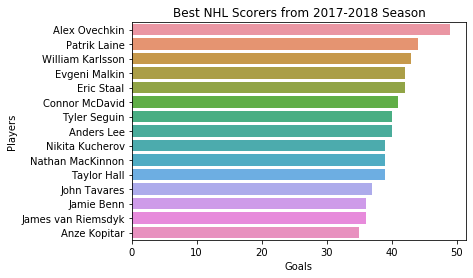

In [15]:
#Create Horizontal Bar Chart
a4 = sns.barplot(y="Name", x="Goals Scored", data= Q4)
a4.set_title("Best NHL Scorers from 2017-2018 Season")
a4.set_xlabel("Goals")
a4.set_ylabel("Players")
a4.set_yticklabels( labels = Q4["Name"])
plt.show()

# Question 5: What players averaged the most assists over the past 3 years?

In [16]:
#Access MySQL
import mysql.connector
from mysql.connector import Error

try: 
    #Attempt to connect
    connection = mysql.connector.connect(user = 'root', 
                                         password = 'Flames2020', 
                                         host = '127.0.0.1', 
                                         database = 'nhl_schema')
        
        
    #Get some information regarding our connection
    if connection.is_connected():
        db_Info = connection.get_server_info()
        print("Connected to MySQL Server version:",db_Info)
        cursor = connection.cursor()
        
        cursor.execute("SELECT database();")
        record = cursor.fetchone()
        print("You are connected to the database",record)
        
        
        #SQL Queries
        cursor.execute("Select P.Name, ROUND(Avg(S.A),1) FROM players as P, stats as S WHERE P.PNum = S.PNum GROUP BY P.Name ORDER BY Avg(S.A) DESC LIMIT 5;")
        result5 = cursor.fetchall()
        print(result5)
        

        

except Error as e: 
    print("Error while connecting to MySQL: ", e)
    
finally:
    if connection.is_connected():
        cursor.close()
        connection.close()
        print("MySQL connection is closed.")
#Make Df of query results
Q5 = DataFrame (result5, columns=['Name', 'Average Assists'])
Q5

Connected to MySQL Server version: 8.0.22
You are connected to the database ('nhl_schema',)
[('Connor McDavid', Decimal('68.3')), ('Nikita Kucherov', Decimal('66.7')), ('Blake Wheeler', Decimal('60.7')), ('Artemi Panarin', Decimal('59.0')), ('Brad Marchand', Decimal('58.0'))]
MySQL connection is closed.


,Name,Average Assists
0,Connor McDavid,68.3
1,Nikita Kucherov,66.7
2,Blake Wheeler,60.7
3,Artemi Panarin,59.0
4,Brad Marchand,58.0


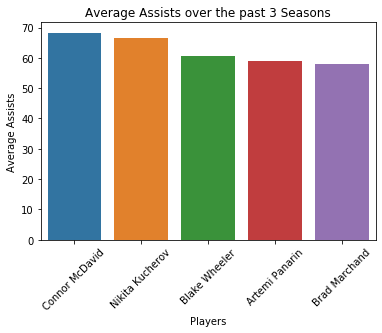

In [17]:
#Make Bar Chart
a5 = sns.barplot(x="Name", y="Average Assists", data= Q5)
a5.set_title("Average Assists over the past 3 Seasons")
a5.set_ylabel("Average Assists")
a5.set_xlabel("Players")
a5.set_xticklabels( labels = Q5["Name"], rotation = 45)
plt.show()

#Show picture of McDavid and Leon
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://a3.espncdn.com/combiner/i?img=%2Fphoto%2F2019%2F1203%2Fr636431_1296x729_16-9.jpg")

# Question 6: Who had the most penalty minutes over the past 3 NHL Seasons?

In [18]:
#Access MySQL
import mysql.connector
from mysql.connector import Error

try: 
    #Attempt to connect
    connection = mysql.connector.connect(user = 'root', 
                                         password = 'Flames2020', 
                                         host = '127.0.0.1', 
                                         database = 'nhl_schema')
        
        
    #Get some information regarding our connection
    if connection.is_connected():
        db_Info = connection.get_server_info()
        print("Connected to MySQL Server version:",db_Info)
        cursor = connection.cursor()
        
        cursor.execute("SELECT database();")
        record = cursor.fetchone()
        print("You are connected to the database",record)
        
        
        #SQL Queries
        cursor.execute("Select P.Name, Sum(PIM) FROM players as P, stats as S WHERE P.PNum = S.PNum GROUP BY P.Name ORDER BY Sum(PIM) DESC LIMIT 5;")
        result6 = cursor.fetchall()
        print(result6)
        

        

except Error as e: 
    print("Error while connecting to MySQL: ", e)
    
finally:
    if connection.is_connected():
        cursor.close()
        connection.close()
        print("MySQL connection is closed.")
#Create DF of query results
from pandas import DataFrame
Q6 = DataFrame (result6, columns=['Name', 'Penalty Minutes'])
Q6

Connected to MySQL Server version: 8.0.22
You are connected to the database ('nhl_schema',)
[('Tom Wilson', Decimal('408')), ('Evander Kane', Decimal('357')), ('Micheal Haley', Decimal('337')), ('Cody McLeod', Decimal('289')), ('Antoine Roussel', Decimal('287'))]
MySQL connection is closed.


,Name,Penalty Minutes
0,Tom Wilson,408
1,Evander Kane,357
2,Micheal Haley,337
3,Cody McLeod,289
4,Antoine Roussel,287


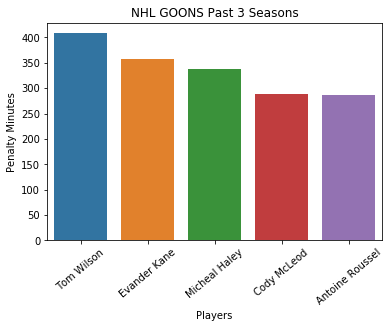

In [19]:
#Create Bar chart
a6 = sns.barplot(x="Name", y="Penalty Minutes", data= Q6)
a6.set_title("NHL GOONS Past 3 Seasons")
a6.set_ylabel("Penalty Minutes")
a6.set_xlabel("Players")
a6.set_xticklabels( labels = Q6["Name"], rotation = 40)

plt.show()
#Get pic of Tom Fighting
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://novacapsfans.files.wordpress.com/2016/08/tom-wilson-fighting.jpg")

# How has Sean Monahan performed based on Points Per Game Played the past few seasons? Does it appear he is going to increase in Points Per Game next year?

In [20]:
#Get pic of Sean Monahan
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://imagesvc.timeincapp.com/v3/fan/image?url=https%3A%2F%2Fflameforthought.com%2Ffiles%2F2016%2F11%2F9634861-sean-monahan-nhl-carolina-hurricanes-calgary-flames.jpg")

In [21]:
#Access MySQL
import mysql.connector
from mysql.connector import Error

try: 
    #Attempt to connect
    connection = mysql.connector.connect(user = 'root', 
                                         password = 'Flames2020', 
                                         host = '127.0.0.1', 
                                         database = 'nhl_schema')
        
        
    #Get some information regarding our connection
    if connection.is_connected():
        db_Info = connection.get_server_info()
        print("Connected to MySQL Server version:",db_Info)
        cursor = connection.cursor()
        
        cursor.execute("SELECT database();")
        record = cursor.fetchone()
        print("You are connected to the database",record)
        
        
        #SQL Queries
        cursor.execute("SELECT S.Season, P.Name, S.PPGP FROM players as P, stats as S WHERE P.PNum = S.PNum AND Name = 'Sean Monahan' ORDER BY S.Season;")
        result7 = cursor.fetchall()
        print(result7)
        

        

except Error as e: 
    print("Error while connecting to MySQL: ", e)
    
finally:
    if connection.is_connected():
        cursor.close()
        connection.close()
        print("MySQL connection is closed.")
#Create Df of Query results
Q7 = DataFrame (result7, columns=['Season','Name', 'PPGP'])
Q7

Connected to MySQL Server version: 8.0.22
You are connected to the database ('nhl_schema',)
[('20172018', 'Sean Monahan', Decimal('0.86')), ('20182019', 'Sean Monahan', Decimal('1.05')), ('20192020', 'Sean Monahan', Decimal('0.69'))]
MySQL connection is closed.


,Season,Name,PPGP
0,20172018,Sean Monahan,0.86
1,20182019,Sean Monahan,1.05
2,20192020,Sean Monahan,0.69


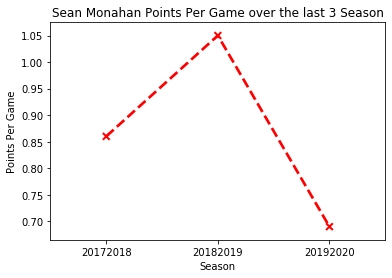

In [22]:
#Create line chart
a7 = sns.pointplot(x="Season", y="PPGP", data= Q7, markers =["x"], linestyles =["--"], color = "red")
a7.set_title("Sean Monahan Points Per Game over the last 3 Season")
a7.set_ylabel("Points Per Game")
a7.set_xlabel("Season")
a7.set_xticklabels( labels = Q7["Season"])

plt.show()

# Question 8: What NHL team(s) had the most player points from 2018-2019 ?

In [23]:
#Access MySQL
import mysql.connector
from mysql.connector import Error

try: 
    #Attempt to connect
    connection = mysql.connector.connect(user = 'root', 
                                         password = 'Flames2020', 
                                         host = '127.0.0.1', 
                                         database = 'nhl_schema')
        
        
    #Get some information regarding our connection
    if connection.is_connected():
        db_Info = connection.get_server_info()
        print("Connected to MySQL Server version:",db_Info)
        cursor = connection.cursor()
        
        cursor.execute("SELECT database();")
        record = cursor.fetchone()
        print("You are connected to the database",record)
        
        
        #SQL Queries
        cursor.execute("SELECT T.TName, Sum(S.P) FROM players as P, teams as T, stats as S WHERE P.PNum = S.PNum AND T.TNum = P.TNum AND S.Season = '20182019' GROUP BY T.TName ORDER BY Sum(S.P) DESC LIMIT 31;")
        result8 = cursor.fetchall()
        print(result8)
        

        

except Error as e: 
    print("Error while connecting to MySQL: ", e)
    
finally:
    if connection.is_connected():
        cursor.close()
        connection.close()
        print("MySQL connection is closed.")

Q8 = DataFrame (result8, columns=['Team','Player Points'])
Q8

Connected to MySQL Server version: 8.0.22
You are connected to the database ('nhl_schema',)
[('TBL', Decimal('859')), ('CGY', Decimal('790')), ('SJS', Decimal('778')), ('TOR', Decimal('730')), ('WSH', Decimal('726')), ('FLA', Decimal('689')), ('WPG', Decimal('688')), ('BOS', Decimal('671')), ('STL', Decimal('655')), ('MTL', Decimal('634')), ('CBJ', Decimal('626')), ('COL', Decimal('624')), ('CHI', Decimal('622')), ('NYI', Decimal('615')), ('PIT', Decimal('614')), ('VGK', Decimal('608')), ('PHI', Decimal('604')), ('CAR', Decimal('598')), ('BUF', Decimal('580')), ('EDM', Decimal('579')), ('NSH', Decimal('553')), ('DET', Decimal('534')), ('DAL', Decimal('528')), ('VAN', Decimal('514')), ('ARI', Decimal('507')), ('NJD', Decimal('499')), ('LAK', Decimal('468')), ('NYR', Decimal('462')), ('OTT', Decimal('443')), ('MIN', Decimal('434')), ('ANA', Decimal('412'))]
MySQL connection is closed.


,Team,Player Points
0,TBL,859
1,CGY,790
2,SJS,778
3,TOR,730
4,WSH,726
5,FLA,689
6,WPG,688
7,BOS,671
8,STL,655
9,MTL,634


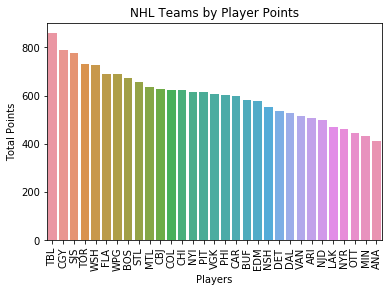

In [24]:
#Create Bar Chart
a8 = sns.barplot(x="Team", y="Player Points", data= Q8)
a8.set_title("NHL Teams by Player Points")
a8.set_ylabel("Total Points")
a8.set_xlabel("Players")
a8.set_xticklabels( labels = Q8["Team"], rotation =90)

plt.show()
#Get pic of Tampa Bay Lightning
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://content.sportslogos.net/logos/1/27/full/93fffgk2v4fm0ugoe2bnkfop6.png")

# Question 9: What players had the most shots over the past 3 years ?

In [25]:
#Access MySQL
import mysql.connector
from mysql.connector import Error

try: 
    #Attempt to connect
    connection = mysql.connector.connect(user = 'root', 
                                         password = 'Flames2020', 
                                         host = '127.0.0.1', 
                                         database = 'nhl_schema')
        
        
    #Get some information regarding our connection
    if connection.is_connected():
        db_Info = connection.get_server_info()
        print("Connected to MySQL Server version:",db_Info)
        cursor = connection.cursor()
        
        cursor.execute("SELECT database();")
        record = cursor.fetchone()
        print("You are connected to the database",record)
        
        
        #SQL Queries
        cursor.execute("Select P.Name, Sum(S.S) FROM players as P, stats as S WHERE P.PNum = S.PNum GROUP BY P.Name ORDER BY Sum(S.S) DESC LIMIT 15;")
        result9 = cursor.fetchall()
        print(result9)
        

        

except Error as e: 
    print("Error while connecting to MySQL: ", e)
    
finally:
    if connection.is_connected():
        cursor.close()
        connection.close()
        print("MySQL connection is closed.")
#Create df of query results
Q9 = DataFrame (result9, columns=['Name','Shots'])
Q9

Connected to MySQL Server version: 8.0.22
You are connected to the database ('nhl_schema',)
[('Alex Ovechkin', Decimal('1004')), ('Nathan MacKinnon', Decimal('967')), ('Tyler Seguin', Decimal('914')), ('Patrick Kane', Decimal('901')), ('Brent Burns', Decimal('857')), ('Brendan Gallagher', Decimal('806')), ('Evander Kane', Decimal('791')), ('Roman Josi', Decimal('787')), ('Jonathan Marchessault', Decimal('781')), ('Jack Eichel', Decimal('776')), ('David Pastrnak', Decimal('760')), ('Dylan Larkin', Decimal('742')), ('John Tavares', Decimal('740')), ('Nikita Kucherov', Decimal('735')), ('Auston Matthews', Decimal('728'))]
MySQL connection is closed.


,Name,Shots
0,Alex Ovechkin,1004
1,Nathan MacKinnon,967
2,Tyler Seguin,914
3,Patrick Kane,901
4,Brent Burns,857
5,Brendan Gallagher,806
6,Evander Kane,791
7,Roman Josi,787
8,Jonathan Marchessault,781
9,Jack Eichel,776


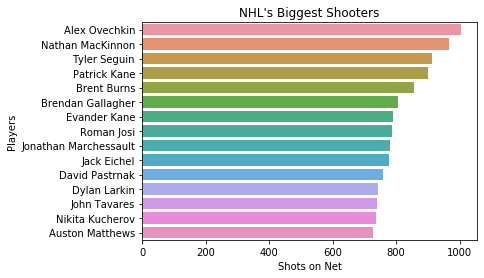

In [26]:
#Create Horizontal Bar Chart
a9 = sns.barplot(y="Name", x="Shots", data= Q9)
a9.set_title("NHL's Biggest Shooters")
a9.set_xlabel("Shots on Net")
a9.set_ylabel("Players")
a9.set_yticklabels( labels = Q9["Name"])

plt.show()
#Show picture of OVI
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "http://www.1310news.com/wp-content/blogs.dir/sites/4/2016/01/08/NY169-128_2015_210154_hd.jpg")

# Question 10: Pick a Player! Where are they trending in terms of Goals/Assists/Points?

In [36]:
#Choose a player from manual input
yourguy = str(input("Please type a player's full first & last name:"))
#Store yourguy in a stringquery
yourguysyntax = "SELECT S.Season, P.Name, S.P, S.G, S.A FROM players as P, stats as S WHERE P.PNum = S.PNum AND Name = \"" + str(yourguy) +"\"  ORDER BY S.Season;"
print(yourguysyntax)

Please type a player's full first & last name: Leon Draisaitl


SELECT S.Season, P.Name, S.P, S.G, S.A FROM players as P, stats as S WHERE P.PNum = S.PNum AND Name = "Leon Draisaitl"  ORDER BY S.Season;


Connected to MySQL Server version: 8.0.22
You are connected to the database ('nhl_schema',)
MySQL connection is closed.


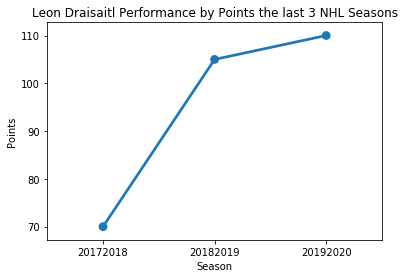

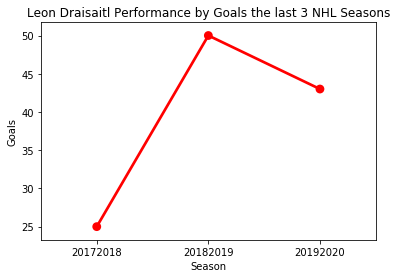

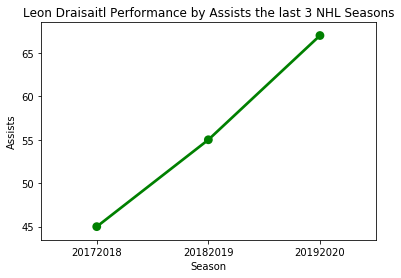

In [37]:
#Access MySQL
import mysql.connector
from mysql.connector import Error

try: 
    #Attempt to connect
    connection = mysql.connector.connect(user = 'root', 
                                         password = 'Flames2020', 
                                         host = '127.0.0.1', 
                                         database = 'nhl_schema')
        
        
    #Get some information regarding our connection
    if connection.is_connected():
        db_Info = connection.get_server_info()
        print("Connected to MySQL Server version:",db_Info)
        cursor = connection.cursor()
        
        cursor.execute("SELECT database();")
        record = cursor.fetchone()
        print("You are connected to the database",record)
        
        
        #SQL Queries
        cursor.execute(yourguysyntax)
        result10 = cursor.fetchall()
    
        

        

except Error as e: 
    print("Error while connecting to MySQL: ", e)
    
finally:
    if connection.is_connected():
        cursor.close()
        connection.close()
        print("MySQL connection is closed.")

#Create df of Query results
Q10 = DataFrame (result10, columns=['Season','Name', 'P', 'G', 'A'])

#Create Player points line chart
a10 = sns.pointplot(x="Season", y="P", data= Q10)
a10.set_title( str(yourguy) + " Performance by Points the last 3 NHL Seasons")
a10.set_ylabel("Points")
a10.set_xlabel("Season")
a10.set_xticklabels( labels = Q10["Season"])

plt.show()

#Create Player Goals line chart
a11 = sns.pointplot(x="Season", y="G", data= Q10, color = 'red')
a11.set_title( str(yourguy) + " Performance by Goals the last 3 NHL Seasons")
a11.set_ylabel("Goals")
a11.set_xlabel("Season")
a11.set_xticklabels( labels = Q10["Season"])


plt.show()

#Create player Assists Line chart
a12 = sns.pointplot(x="Season", y="A", data= Q10, color = 'green')
a12.set_title( str(yourguy) + " Performance by Assists the last 3 NHL Seasons")
a12.set_ylabel("Assists")
a12.set_xlabel("Season")
a12.set_xticklabels( labels = Q10["Season"])

plt.show()

# Thank you !